In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline
#set to see all columns of data
pd.set_option('display.max_columns', 999)

In [2]:
df = pd.read_csv('Cleaned.csv', index_col = 0)

In [3]:
df.head()

,CustomerID,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer,AveMonthSpend,Age,dummy,log_Age,log_YearlyIncome,log_AveMonthSpend
0,11000,Jon,Yang,3761 N. 14th St,Rockhampton,Queensland,Australia,4700,1 (11) 500 555-0162,1966-04-08,Bachelors,Professional,M,M,1,0,0,2,137947,0,89,54,1.0,3.988984,11.834625,4.488636
1,11001,Eugene,Huang,2243 W St.,Seaford,Victoria,Australia,3198,1 (11) 500 555-0110,1965-05-14,Bachelors,Professional,M,S,0,1,3,3,101141,1,117,55,1.0,4.007333,11.524271,4.762174
2,11002,Ruben,Torres,5844 Linden Land,Hobart,Tasmania,Australia,7001,1 (11) 500 555-0184,1965-08-12,Bachelors,Professional,M,M,1,1,3,3,91945,0,123,55,1.0,4.007333,11.428946,4.812184
3,11003,Christy,Zhu,1825 Village Pl.,North Ryde,New South Wales,Australia,2113,1 (11) 500 555-0162,1968-02-15,Bachelors,Professional,F,S,0,1,0,0,86688,0,50,52,1.0,3.951244,11.370071,3.912023
4,11004,Elizabeth,Johnson,7553 Harness Circle,Wollongong,New South Wales,Australia,2500,1 (11) 500 555-0131,1968-08-08,Bachelors,Professional,F,S,1,4,5,5,92771,1,95,52,1.0,3.951244,11.437889,4.553877


In [4]:
df.shape

(16404, 26)

In [5]:
df.columns

Index(['CustomerID', 'FirstName', 'LastName', 'AddressLine1', 'City',
       'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber',
       'BirthDate', 'Education', 'Occupation', 'Gender', 'MaritalStatus',
       'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'TotalChildren', 'YearlyIncome', 'BikeBuyer', 'AveMonthSpend', 'Age',
       'dummy', 'log_Age', 'log_YearlyIncome', 'log_AveMonthSpend'],
      dtype='object')

In [6]:
buyer_counts = df[['CustomerID', 'BikeBuyer']].groupby('BikeBuyer').count()
print(buyer_counts)

#unbalanced group

           CustomerID
BikeBuyer            
0               10949
1                5455


## Prepare data for models

In [7]:
labels = np.array(df['BikeBuyer'])
#labels.shape

In [8]:
#Encode classification features
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Education', 'Occupation', 'Gender', 'MaritalStatus',
       'HomeOwnerFlag']

Features = encode_string(df['CountryRegionName'])
for col in categorical_columns:
    temp = encode_string(df[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])  

(16404, 22)
[[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.]]


In [9]:
#Concatenate numeric features
Features = np.concatenate([Features, np.array(df[['NumberCarsOwned', 'NumberChildrenAtHome',
       'TotalChildren','Age','YearlyIncome']])], axis = 1)
print(Features.shape)
print(Features[:5, :])   

(16404, 27)
[[1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  2.00000e+00 5.40000e+01 1.37947e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 1.00000e+00 3.00000e+00
  3.00000e+00 5.50000e+01 1.01141e+05]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 1.00000e+00 3.00000e+00
  3.00000e+00 5.50000e

In [10]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [11]:
X_train.shape
X_test.shape

(3281, 27)

In [12]:
#Rescale numeric features
scaler = preprocessing.StandardScaler().fit(X_train[:,22:])
X_train[:,22:] = scaler.transform(X_train[:,22:])
X_test[:,22:] = scaler.transform(X_test[:,22:])
X_train[:5,]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.43971318, -0.65347453, -1.19026902,
        -1.37010422, -0.63468598],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        , -1.30914454, -0.65347453,  1.18420752,
         0.22627031,  0.35304315],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.    

### Construct linear regression model


In [13]:
logistic_mod = linear_model.LogisticRegression() 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-1.01336544]
[[-0.14902877  0.10785338  0.02261039 -0.03491972  0.05887057 -0.0064777
   0.40347717  0.12250261 -0.11545607  0.02948458 -0.44110014  0.00903067
  -0.57747407  0.28251204  0.10622929  0.17861021 -0.30828881  0.30719696
  -0.75942583  0.75833398 -0.05531438  0.05422253 -0.07050963  1.08393266
   0.10017361 -0.41395947  0.5947847 ]]


In [15]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.96568681 0.03431319]
 [0.8747513  0.1252487 ]
 [0.76628476 0.23371524]
 [0.5000459  0.4999541 ]
 [0.1997765  0.8002235 ]
 [0.62763997 0.37236003]
 [0.63180985 0.36819015]
 [0.89256227 0.10743773]
 [0.69574309 0.30425691]
 [0.93390676 0.06609324]
 [0.43027113 0.56972887]
 [0.75389207 0.24610793]
 [0.33886485 0.66113515]
 [0.89868897 0.10131103]
 [0.92640832 0.07359168]]


Text(0, 0.5, 'Frequency')

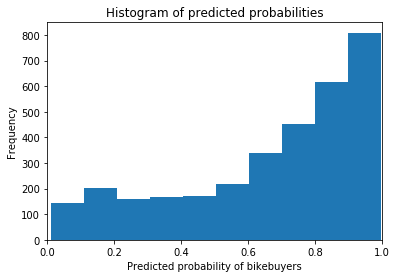

In [16]:
# store the predicted probabilities for class 1
y_pred_prob0 = probabilities[:, 0]
y_pred_prob1 = probabilities[:, 1]

# histogram of predicted probabilities

plt.hist(y_pred_prob0)

#plt.hist(y_pred_prob1)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of bikebuyers')
plt.ylabel('Frequency')

### Score and evaluate model

In [17]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0]


In [18]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
Actual positive      1944               238
Actual negative       501               598

Accuracy  0.77
 
           Positive      Negative
Num case     2182          1099
Precision    0.80          0.72
Recall       0.89          0.54
F1           0.84          0.62


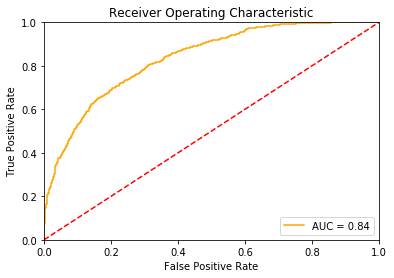

In [19]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)  

#### Choose a weighted model

In [20]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:0.33, 1:0.67}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.33, 1: 0.67}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.93694457 0.06305543]
 [0.77332257 0.22667743]
 [0.62636132 0.37363868]
 [0.34669566 0.65330434]
 [0.10880191 0.89119809]
 [0.44709287 0.55290713]
 [0.45707988 0.54292012]
 [0.80733919 0.19266081]
 [0.55689348 0.44310652]
 [0.87953906 0.12046094]
 [0.26633023 0.73366977]
 [0.60457636 0.39542364]
 [0.19352768 0.80647232]
 [0.81316514 0.18683486]
 [0.86006987 0.13993013]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive      1684               498
Actual negative       319               780

Accuracy  0.75
 
           Positive      Negative
Num case     2182          1099
Precision    0.84          0.61
Recall       0.77          0.71
F1           0.80          0.66


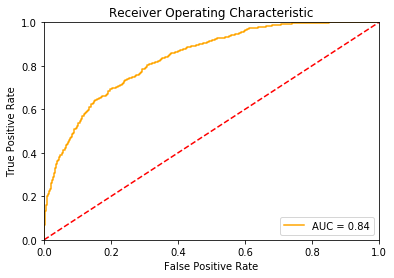

In [22]:
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities)  

In [23]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.55, 0.60, 0.65, 0.7, 0.75]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.55
                 Confusion matrix
                 Score positive    Score negative
Actual positive      1790               392
Actual negative       372               727

Accuracy  0.77
 
           Positive      Negative
Num case     2182          1099
Precision    0.83          0.65
Recall       0.82          0.66
F1           0.82          0.66

For threshold = 0.6
                 Confusion matrix
                 Score positive    Score negative
Actual positive      1870               312
Actual negative       414               685

Accuracy  0.78
 
           Positive      Negative
Num case     2182          1099
Precision    0.82          0.69
Recall       0.86          0.62
F1           0.84          0.65

For threshold = 0.65
                 Confusion matrix
                 Score positive    Score negative
Actual positive      1929               253
Actual negative       471               628

Accuracy  0.78
 
           Positive      Negative
Num cas

Mean Square Error      = 0.24900944833892105
Root Mean Square Error = 0.4990084651976568
Mean Absolute Error    = 0.24900944833892105
Median Absolute Error  = 0.0
R^2                    = -0.1178302247939762


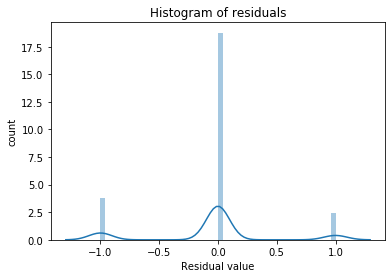

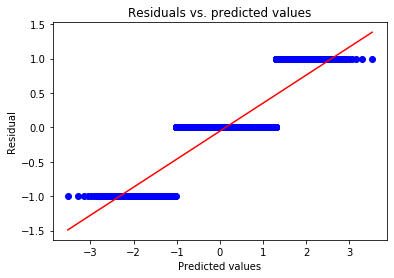

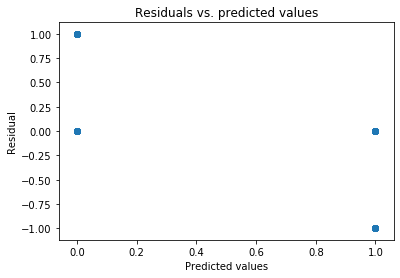

In [24]:
#!!! CANNOT PLOT RESIDUALS FOR CLASSIFICATION PROBLEM
# RESIDUAL VALUE IS NOT CONTINUOUS VALUE


import scipy.stats as ss
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()
    
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test, y_score)
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()
  

y_score = logistic_mod.predict(X_test) 
print_metrics(y_test, y_score) 
hist_resids(y_test, y_score)  
resid_qq(y_test, y_score) 
resid_plot(y_test, y_score) 